# Darija Language Identification using FastText:
*"Is this text written in Moroccan Darija or another arabic dialect?"*

This notebook demonstrates language identification of Darija among other arabic dialects using FastText. This task is important for many applications, specifically for data quality filtering.

The dataset used is AtlasIA's Darija-LID dataset [https://huggingface.co/datasets/atlasia/Darija-LID](https://huggingface.co/datasets/atlasia/Darija-LID).
There is no restriction on the choice of the dataset, you can use any other dataset that can help you achieve the task.

- **Setup**
    - Installs and imports required packages: fasttext, datasets, pandas, scikit-learn, seaborn

- **Data Preparation**
    - Loads and preprocesses text data
    - Exploratory data analysis

- **Model Training & Evaluation**
    - Trains FastText model on prepared data
    - Evaluates model performance

- **Hyperparameter Tuning**
    - Adjusts model parameters for better performance

- **Requirements**
    - Python >= 3.10
    - See pip install commands in notebook for package requirements

Read more about FastText [https://fasttext.cc/docs/en/supervised-tutorial.html](https://fasttext.cc/docs/en/supervised-tutorial.html).

# Setup

In [ ]:
! pip install -q fasttext
! pip install -q -U datasets
! pip install -q pandas
! pip install -q scikit-learn
! pip install -q seaborn

# Optional for data visualization
! pip install -q arabic-reshaper
! pip install -q wordcloud
! pip install -q python-bidi

##IGNORE THE ERROR

In [2]:
import fasttext
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from datasets import load_dataset

In [3]:
# DO NOT DELETE/HIDE THIS FUNCTION
def validate_fasttext_format(file_path) -> dict:
    """Utility function to validate the format of the data for fasttext"""
    n_errors = 0
    emptylines = []
    labelmissing = []
    spacemissing = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f, 1):
            if not line.strip():
                #print(f"Empty line found at line {i}")
                emptylines.append(i)
                n_errors += 1
                continue
            if not line.startswith('__label__'):
                # print(f"Line {i} doesn't start with __label__: {line[:100]}")
                labelmissing.append(i)
                n_errors += 1
                continue
            if ' ' not in line:
                # print(f"Line {i} has no space after label: {line[:100]}")
                spacemissing.append(i)
                n_errors += 1
                continue
    errors_report = {
        'empty line': emptylines,
        '__label__ missing': labelmissing,
        'whitespace missing': spacemissing
        }
    print(f"Data format validation complete. Found {n_errors} errors.")
    return errors_report


# Load and explore data

In [ ]:
# Load data from AtlasIA -- You can change the dataset if you want
data = load_dataset('atlasia/Darija-LID')

train_data = data['train']
test_data = data['test']

train_data = train_data.to_pandas()
test_data = test_data.to_pandas()

#### Preprocessing

In [6]:
def preprocess_text(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    # remove urls
    text = re.sub(r'http\S+', '', text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # remove Latin characters but keep Arabic text
    text = re.sub(r'[a-zA-Z]', '', text)
    # remove emojis but keep Arabic text
    text = re.sub(r'[^\w\s\u0600-\u06FF]', '', text)
    text = text.lower()
    return text

train_data['processed_text'] = train_data['text'].apply(preprocess_text)
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

#### Distribution of Number of Words in train data

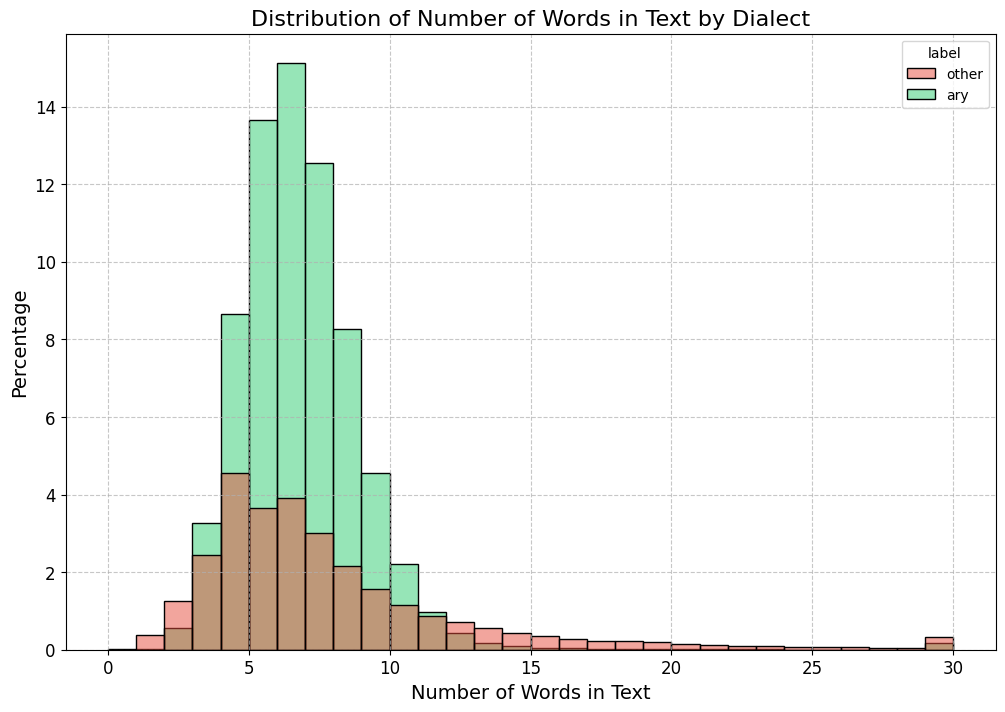

In [7]:
palette = {'ary': '#2ecc71', 'other': '#e74c3c'}

# recalculate text length
train_data['text_length'] = train_data['processed_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 8))
sns.histplot(
    data=train_data.assign(text_length_clipped=train_data['text_length'].clip(upper=30)),
    x='text_length_clipped',
    hue='label',
    bins=30,
    palette=palette,
    multiple="layer",
    stat='percent'
)
plt.title('Distribution of Number of Words in Text by Dialect', fontsize=16)
plt.xlabel('Number of Words in Text', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


#### Most common words in Ary vs Other dialects (train data)

Download the arabic font from https://fonts.google.com/specimen/Amiri


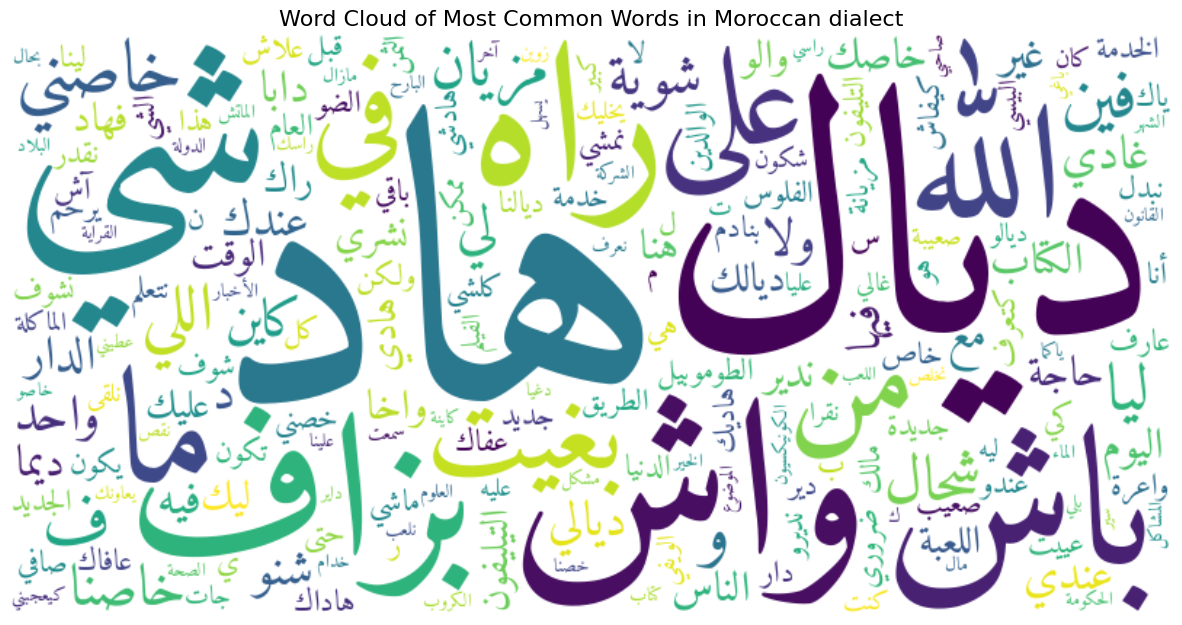

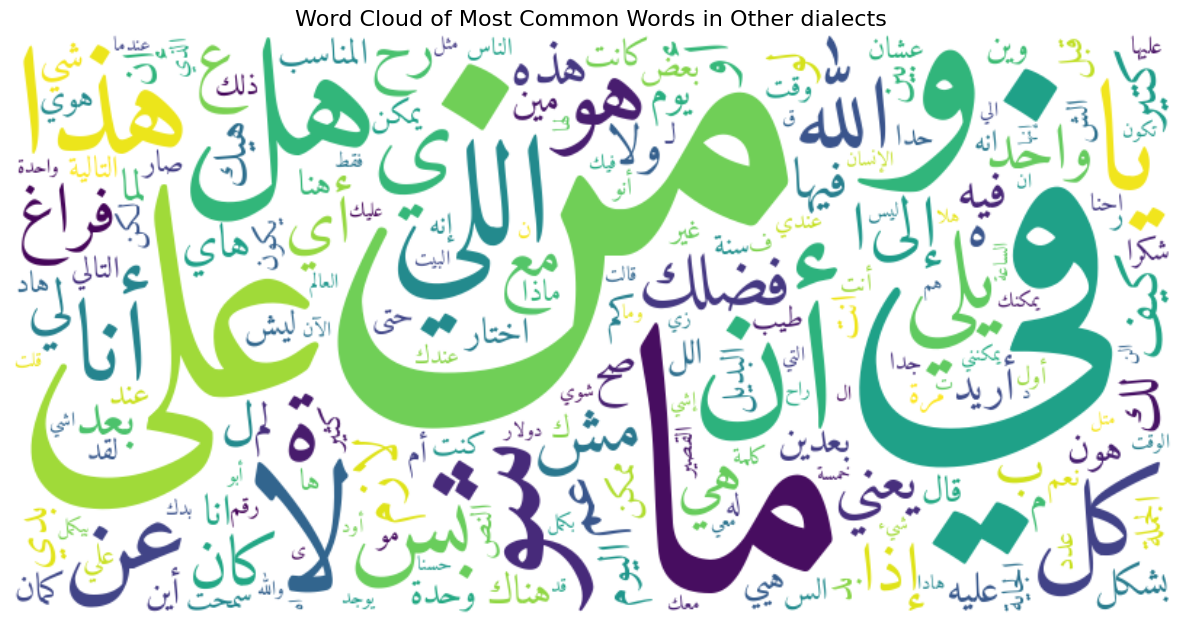

In [11]:
import arabic_reshaper
from bidi.algorithm import get_display
from collections import Counter
from heapq import nlargest
from wordcloud import WordCloud

font_path = 'Amiri-Regular.ttf'

words_counts_ary = Counter(' '.join(train_data[train_data['label'] == 'ary']['processed_text']).split())
words_counts_other = Counter(' '.join(train_data[train_data['label'] == 'other']['processed_text']).split())

# Function to preprocess Arabic text
def preprocess_arabic_words(word_freq):
    reshaped_word_freq = {}
    for word, freq in word_freq.items():
        reshaped_word_freq[word] = freq
    return reshaped_word_freq


# ------------------top 1k words in Ary------------------------------------
top_word_counts = dict(nlargest(1000, words_counts_ary.items(), key=lambda x: x[1]))
reshaped_word_counts = preprocess_arabic_words(top_word_counts)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    font_path=font_path
).generate_from_frequencies(reshaped_word_counts)

# plot the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Moroccan dialect', fontsize=16)
plt.show()


# ------------------top 1k words in Other------------------------------------
top_word_counts = dict(nlargest(1000, words_counts_other.items(), key=lambda x: x[1]))
reshaped_word_counts = preprocess_arabic_words(top_word_counts)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    font_path=font_path
).generate_from_frequencies(reshaped_word_counts)

# plot the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Other dialects', fontsize=16)
plt.show()


# Train (binary)

In [14]:
# data should have a specific format for fasstext
data_train = train_data[['label', 'processed_text']].copy()
data_train['label'] = '__label__' + data_train['label']

data_test = test_data[['label', 'processed_text']].copy()
data_test['label'] = '__label__' + data_test['label']

# save
data_train.to_csv('data_train.txt', header=None, index=None, sep=' ', mode='w')
data_test.to_csv('data_test.txt', header=None, index=None, sep=' ', mode='w')

In [16]:
# Validate the data
print("\nTrain Data")
_ = validate_fasttext_format('data_train.txt') # you can get the report of errors if there are any
print("\nTest Data")
_ = validate_fasttext_format('data_test.txt') # you can get the report of errors if there are any


Train Data
Data format validation complete. Found 0 errors.

Test Data
Data format validation complete. Found 0 errors.


In [17]:

training_params = {
    "lr": 0.1,
    "epoch": 5,
    "dim": 100,
    "minCount": 1,
    "wordNgrams": 5,
    "bucket": 200,
    "loss": "softmax",
}

model = fasttext.train_supervised('data_train.txt', **training_params)


# Evaluate

In [18]:
with open('data_test.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

samples = list(map(lambda x:x.replace('\n', ''), lines))
texts = [' '.join(x.split()[1:]) for x in lines]
preds = model.predict(texts)

# get __label__ from preds
y_hat = [x[0].split('__label__')[1] for x in preds[0]]
# get __label__ from lines
y_true = [x.split('__label__')[1].split()[0] for x in lines]



Classification Report:
              precision    recall  f1-score   support

         ary       0.96      0.54      0.69     37761
       other       0.46      0.94      0.61     15465

    accuracy                           0.66     53226
   macro avg       0.71      0.74      0.65     53226
weighted avg       0.81      0.66      0.67     53226



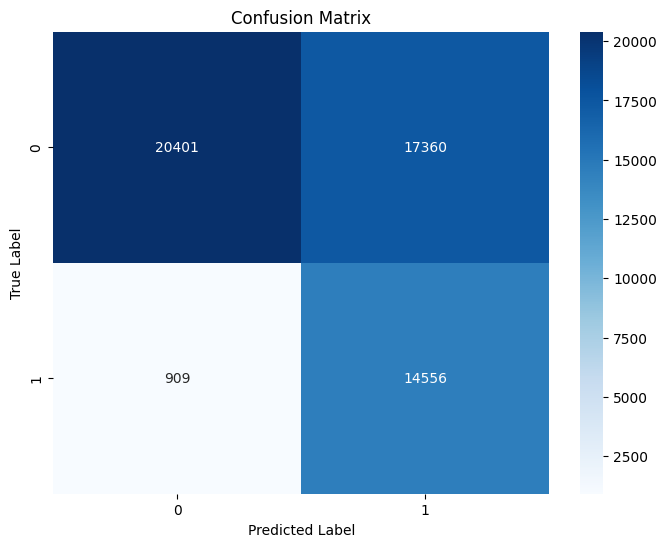

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_true, y_hat)
precision = precision_score(y_true, y_hat, pos_label='ary')
recall = recall_score(y_true, y_hat, pos_label='ary')
f1 = f1_score(y_true, y_hat, pos_label='ary')


print("\nClassification Report:")
print(classification_report(y_true, y_hat))


cm = confusion_matrix(y_true, y_hat)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Hyperparameter tuning
- You can use FastText's built-in hyperparameter tuning [https://fasttext.cc/docs/en/autotune.html](https://fasttext.cc/docs/en/autotune.html)
- Or you can use a custom grid search

In [20]:
# prepare validation data
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data_train, test_size=0.2, random_state=7)

# save validation data
val_data.to_csv('data_val.txt', header=None, index=None, sep=' ', mode='w')

              precision    recall  f1-score   support

         ary       0.98      0.96      0.97     37761
       other       0.90      0.96      0.93     15465

    accuracy                           0.96     53226
   macro avg       0.94      0.96      0.95     53226
weighted avg       0.96      0.96      0.96     53226



Text(0.5, 36.72222222222221, 'Predicted Label')

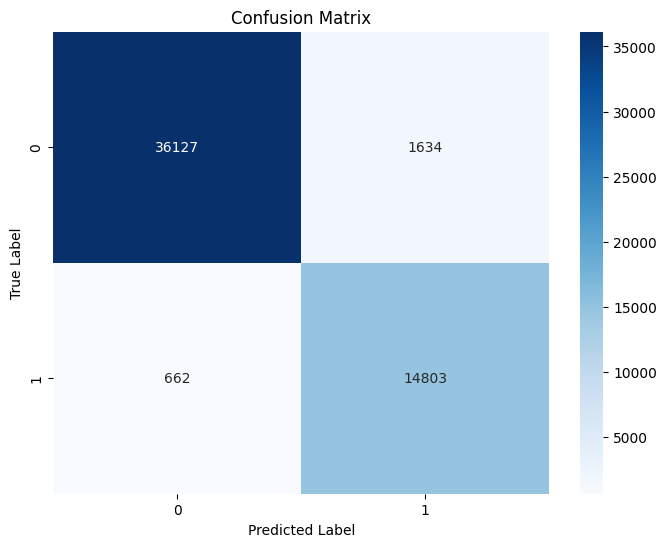

In [21]:
# You can use FastText's built-in hyperparameter tuning

model = fasttext.train_supervised('data_train.txt', autotuneValidationFile='data_val.txt')

# Evaluate
with open('data_test.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

samples = list(map(lambda x:x.replace('\n', ''), lines))
texts = [' '.join(x.split()[1:]) for x in lines]
preds = model.predict(texts)

# get __label__ from preds
y_hat = [x[0].split('__label__')[1] for x in preds[0]]
# get __label__ from lines
y_true = [x.split('__label__')[1].split()[0] for x in lines]

print(classification_report(y_true, y_hat))


cm = confusion_matrix(y_true, y_hat)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')



# Challenge Questions
- For this task, what is the most important metric to optimize?

    Depends on the task:

    Task Type	             :              Metric

    Balanced classification:	             Accuracy

    Imbalanced classes	   :              F1-score
- Can you think of another architecture that can be used to achieve this task?

    AraBERT: Transformer-based models pretrained on Arabic
- How can you improve the performance of the model?

    Balance classes: Use oversampling or undersampling.

    Use better tokenization: Especially for Arabic.
    
